# next_frame_pred_no_arms_02_results

We trained a time prediction model on [Active Matter microscopy videos](https://www.youtube.com/watch?v=aJrB5MMPqhA&ab_channel=ThomsonLab) for 100 epochs (we focused only on isolated microtubule networks organized by polygonal light patterns). See `next_frame_pred_no_arms_02.py`, which is the script containing the training details.

We saved weights, validation, and training loss values. 

---
Our proposed method takes as input the video frame at time $t$ and a change in time $\Delta t$ to output a prediction for the video frame at time $t + \Delta t$. 

First, a convolutional autoencoder maps an image $\mathbf{X}_t$ to a latent representation $\mathbf{z}_t$. Here $t$ is physical time.
$$\mathbf{X}_t \mapsto \mathbf{z}_t$$

Then, a linear time translation operator translates the image embedding $\mathbf{z}_t$ by a learned time embedding $\boldsymbol{\phi}$, scaled by time shift $\Delta t$; namely: $$\mathbf{z}_t \mapsto (\mathbf{z}_t + \Delta t \boldsymbol{\phi}) $$

Finally, a convolutional decoder takes the translated image embedding and predicts the frame at time $t + \Delta t$. 
$$(\mathbf{z}_t + \Delta t \boldsymbol{\phi }) \mapsto \mathbf{\tilde{X}}_{t + \Delta t}$$

---



In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import tqdm
from TCAE import *
from helper_functions import *
from image_processing_functions import *

experiment_name = "next_frame_pred_no_arms_02"

base_dir = os.path.join(os.getcwd(),experiment_name)
weights_dir = os.path.join(base_dir,'weights')
history_dir = os.path.join(base_dir,'history')
pred_images_dir = os.path.join(base_dir,'pred_images')
area_images_dir = os.path.join(base_dir,'area_images')
gif_dir = os.path.join(base_dir,'gif')

# Create Directories to save results
create_dir(pred_images_dir)
create_dir(area_images_dir)
create_dir(gif_dir)

In [2]:
# Instantiate model
latent_dim = 2048
tcae = TConvAutoEncoder(latent_dim)
# Load weights
# A 'dummy' forward pass is necessary to 'connect' model.
tcae((np.zeros((1,112,112,1), dtype = 'float32'), 
      np.zeros((1,1), dtype = 'float32'))
); 
# Select weigths with best validation loss
# In next section we can see val loss
tcae.load_weights(sorted(glob.glob(weights_dir + '/*'))[2])

### Training and Validation Loss

We trained our model 100 epochs. Let's visualize training and validation loss.

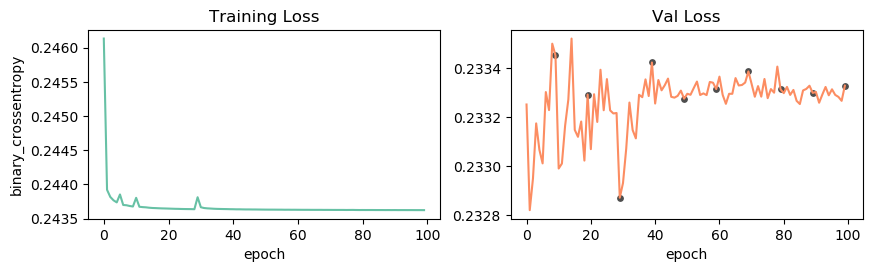

In [3]:
df = pd.read_csv(glob.glob(history_dir+"/*")[0])
plt.figure(figsize=(10,2.5), dpi = 100)
plt.subplot(1,2,1)
plt.plot(df['epoch'], df['loss'], c = '#67C1A5')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('binary_crossentropy')
plt.subplot(1,2,2)
plt.plot(df['epoch'], df['val_loss'], c = '#FC8D62')
plt.scatter(
    df['val_loss'][[((i+1)*10) -1  for i in range(10)]].index,
    df['val_loss'][[((i+1)*10) -1  for i in range(10)]].values,
    s = 15,
    c = '#4D4D4D',
)
plt.xlabel('epoch')
plt.title('Val Loss');

### TCAE predictions on validation and training data

In [4]:
# Let's load some data to see the model's predictions
start_frame = 30
end_frame = 230

file_list = glob.glob("/home/ubuntu/am-cvae/data/112x112_pulse/*")
file_list_training = [file for file in file_list if not "rec600" in file ] # rec600 video is val set
file_list_val = [file for file in file_list if "rec600" in file ]
val_data = np.load(file_list_val[0])[start_frame:end_frame]
val_data = np.expand_dims(val_data, -1).astype("float32")
train_example = np.load([file for file in file_list_training if 'hex750' in file][0])[start_frame:end_frame]
train_example = np.expand_dims(train_example, -1).astype('float32')

We will predict a total of `n_frames` timesteps starting by a given observation at time = `initial frame`. We will save the images of our predictions:

In [5]:
initial_frame = 60
n_frames = 40
for dt in tqdm.tqdm(range(n_frames)):
    # Feeding same initial frame to the model, only varying dt.
    dt_vector = np.array([[dt]], dtype = 'float32')
    pred_val = tcae.predict((val_data[initial_frame:initial_frame+1], dt_vector))
    pred_train = tcae.predict((train_example[initial_frame:initial_frame+1], dt_vector))
    
    fig = plt.figure(figsize=(9,7))
    
    ax1 = plt.subplot(2,3,1)
    plt.imshow(train_example[initial_frame,:,:,0])
    ax1.set_title(f"Train initial t =  {initial_frame}")
    plt.axis('off')
    
    ax2 = plt.subplot(2,3,2)
    plt.imshow(pred_train[0,:,:,0])
    ax2.set_title(f"prediction t = {initial_frame}+{dt}")
    plt.axis('off')
    
    ax3 = plt.subplot(2,3,3)
    plt.imshow(train_example[initial_frame + dt, :,:,0])
    ax3.set_title(f"GT t = {initial_frame}+{dt}")
    plt.axis('off')

    
    ax4 = plt.subplot(2,3,4)
    plt.imshow(val_data[initial_frame,:,:,0])
    ax4.set_title(f"val initial t =  {initial_frame}")
    plt.axis('off')
    
    ax5 = plt.subplot(2,3,5)
    plt.imshow(pred_val[0,:,:,0])
    ax5.set_title(f"prediction t = {initial_frame}+{dt}")
    plt.axis('off')
    
    ax6 = plt.subplot(2,3,6)
    plt.imshow(val_data[initial_frame + dt,:,:,0])
    ax6.set_title(f"GT t = {initial_frame}+{dt}")
    plt.axis('off')
    
    plt.savefig(
        os.path.join(pred_images_dir, f"time_pred_{str(dt).zfill(4)}"), 
        bbox_inches='tight',
        pad_inches=0.1,
    )
    plt.close()

100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


Our predictions are videos, so it is better to display them using an animated GIF.

In [6]:
gif_pred_path = os.path.join(gif_dir,'tcae_preds.gif')
create_gif(gif_pred_path, pred_images_dir)

100%|██████████| 40/40 [00:01<00:00, 23.93it/s]



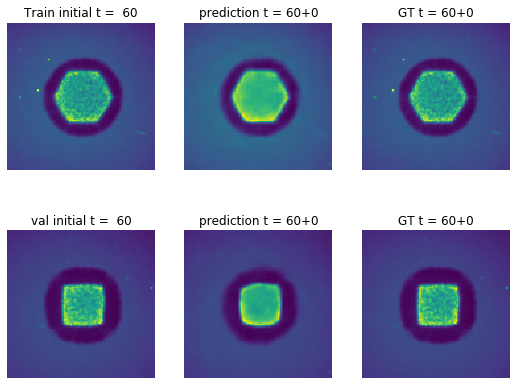

In [7]:
embed.embed_file(gif_pred_path)

### Microtubule area quantification: Predictions vs. Groud Truth

We can quantify the area of the microtubule network in every image (data and prediction) by applying a segmentation pipeline. After segmentation, we need to count the pixels that have a value of 1. 



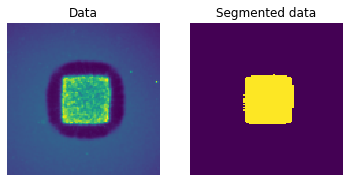

In [8]:
# Let's look at an example of image segmenation:
id_example = 50
bin_mask = thresholding(val_data[id_example:id_example + 1], method = 'triangle')
bin_mask = remove_objects(bin_mask, min_size=100)
plt.subplot(1,2,1)
plt.imshow(val_data[id_example:id_example + 1][0,:,:,0])
plt.axis('off')
plt.title('Data')
plt.subplot(1,2,2)
plt.imshow(bin_mask[0,:,:,0])
plt.axis('off')
plt.title('Segmented data');

In [9]:
def get_area_mt_network(images):
    '''
    Apply a chain of multiple image processing operations to array of images. 
    The output is the area of microtubule network (in pixels)

    Args:
    images (numpy array): numpy array with images. shape = (n, height, width, channels)
    '''
    bin_images = thresholding(images, method = 'triangle')
    bin_images = remove_objects(bin_images, min_size=100)
    return count_pixels(bin_images)

For both: a train example and a validation example,

We will take as initial observation each frame, from $t = 0$ to $t = 150$, and predict 50 frames ($\Delta t \in \{0,1,2,\ldots 49,50\}$).

In [10]:
dt = np.tile(np.r_[slice(0,50,1)], 150) # predict 50 frames starting from 150 initial frames.
dt = dt.reshape((dt.shape[0], 1)).astype('float32')

x_train = np.repeat(train_example[:-50], 50, axis=0) # select the first 150 frames and repeat them 50 times.
x_val = np.repeat(val_data[:-50], 50,  axis=0) # select the first 150 frames and repeat them 50 times.
y_train = tcae.predict((x_train, dt))
y_val = tcae.predict((x_val, dt))

# compute the area of mt network
area_x_train = get_area_mt_network(train_example)
area_y_train = get_area_mt_network(y_train).astype('float32')
area_x_val = get_area_mt_network(val_data)
area_y_val = get_area_mt_network(y_val).astype('float32')

Since we have predicted 50 frames from 150 different initial frames, we will plot 150 area comparisons. 

In [11]:
for frame in tqdm.tqdm(range(0,150)):
    fig = plt.figure(figsize=(12,4))
    ax1= plt.subplot(1,2,1)
    plt.scatter(range(150+50), area_x_train, s =.3, alpha = .2, )
    plt.plot(range(20,150+50),area_x_train[20:], alpha = .2, label = 'Data')
    plt.scatter(range(frame, frame+50), area_y_train[50*frame:50*(frame+1)], s =1 , label = 'Prediction')
    plt.scatter(frame, area_y_train[50*frame], s =10 ,c='k', marker = '^', label = f'initial t = {frame}')
    plt.ylim((0,2500))
    plt.xlabel('time in frames')
    plt.ylabel('area in pixels')
    plt.legend()
    ax1.set_title('Training Data')

    ax2= plt.subplot(1,2,2)
    plt.scatter(range(150+50), area_x_val, s =.3, alpha = .2)
    plt.plot(range(10,150+50),area_x_val[10:], alpha = .2, label = 'Data')
    plt.scatter(range(frame, frame+50), area_y_val[50*frame:50*(frame+1)], s =1 , label = 'Prediction')
    plt.scatter(frame, area_y_val[50*frame], s =10 ,c='k', marker = '^', label = f'initial t = {frame}')
    plt.ylim((0,2500))
    plt.xlabel('time in frames')
    plt.ylabel('area in pixels')
    plt.legend()
    ax2.set_title('Validation Data')
    
    plt.savefig(
        os.path.join(area_images_dir, f"area_prediction_{str(frame).zfill(4)}"),
        bbox_inches='tight',
        pad_inches=0.1,
    )
    plt.close()

100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


Let's visualize our 150 plots using an animated GIF. $t$ is our initial observation. The number of orange points is 50.

In [12]:
gif_area_path = os.path.join(gif_dir,'tcae_area.gif')
create_gif(gif_area_path, area_images_dir)

100%|██████████| 150/150 [00:05<00:00, 28.58it/s]



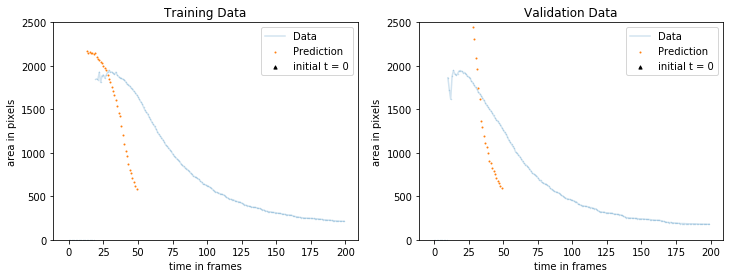

In [13]:
embed.embed_file(gif_area_path)

For training and validation data, the area of the predicted microtubule network follows the area of the mt net in actual data closely. 